In [1]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np
import scipy as sp
import sys

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
from nltk.stem.porter import *
from gensim.models import ldamodel
import gensim.corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim import models,corpora
import gensim.models.phrases as gen
from gensim.models.coherencemodel import CoherenceModel
#from gensim.summarization import summarize,keywords

import pyLDAvis
import pyLDAvis.gensim_models

from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')




C:\Users\nsmit\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


# Loading Data


In [2]:
data=pd.read_csv('data_classified.csv')
len(data)

138

In [3]:
data.head(5)

,MONTH,YEAR,NAME,OCCUPATION,COMMENT,Short Comments by Individual,Activism Letters,Think tank letters,Sentiment_Polarity,Evidence,Key Words,specific_sentiment,specific_evidence,specific_key,suggestion sentence,assertion sentence,Unnamed: 16
0,AUG,2020,Mr. Del Bigtree,"Founder, Informed Consent Action Network (ICAN)",My name is Del Bigtree. I speak for the Inform...,0,1,0,1,that you sit in an unprecedented moment of the...,"accidents,rushing,dangerous",0,0,0,We should be having all sorts of animal trials...,We should be having all sorts of animal trials...,NaN
1,AUG,2020,Andre Montoya-Barthelemy,"MD,HealthPartners Occupational and Environment...",My name is Andre Montoya-Barthelemy. First of ...,0,1,0,4,Vaccination here will go farther. It will save...,"save, lives, good, prison",0,0,0,"So, I’m imploring you to protect those individ...",Recent research demonstrates death rates up to...,NaN
2,AUG,2020,Santa Ric Erwin,"Chairman, Board of Directors,Fraternal Order o...",Thank you. Not since the depths of the Great D...,0,1,0,4,Promising vaccines are in Phase 3 testing alre...,"social restrictions, early access",0,0,0,We’re asking that professional Santas and othe...,0,NaN
3,AUG,2020,Ms. Dorit Reiss,"Professor of Law,Hastings College of the Law,U...","Well, even as a Jew, I realize that Santa is a...",1,0,0,2,I also want to remind everyone that it is not ...,"oversight, public, transparency",0,0,0,It is critical that any decision about COVID-1...,0,NaN
4,AUG,2020,"C. Grace Whiting, JD","President and Chief Executive Officer , Nation...",Hi. Good afternoon. I’m Grace Whiting. I’m the...,0,1,0,4,First is that family caregivers can be valuabl...,"caregiver, incentivize, prevent",0,0,0,We would encourage this committee to consider ...,Despite broad support from this committee and ...,NaN


In [4]:
df1 = data.iloc[:, 8:]
df1.head()

,Sentiment_Polarity,Evidence,Key Words,specific_sentiment,specific_evidence,specific_key,suggestion sentence,assertion sentence,Unnamed: 16
0,1,that you sit in an unprecedented moment of the...,"accidents,rushing,dangerous",0,0,0,We should be having all sorts of animal trials...,We should be having all sorts of animal trials...,NaN
1,4,Vaccination here will go farther. It will save...,"save, lives, good, prison",0,0,0,"So, I’m imploring you to protect those individ...",Recent research demonstrates death rates up to...,NaN
2,4,Promising vaccines are in Phase 3 testing alre...,"social restrictions, early access",0,0,0,We’re asking that professional Santas and othe...,0,NaN
3,2,I also want to remind everyone that it is not ...,"oversight, public, transparency",0,0,0,It is critical that any decision about COVID-1...,0,NaN
4,4,First is that family caregivers can be valuabl...,"caregiver, incentivize, prevent",0,0,0,We would encourage this committee to consider ...,Despite broad support from this committee and ...,NaN


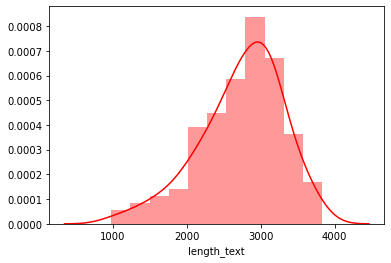

In [5]:
data['length_text'] = data['COMMENT'].str.len()
sns.distplot(data['length_text'], color="r")
plt.show()

In [6]:
comment = [x for x in data['COMMENT']] #docs

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nsmit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Data Preprocessing


In [9]:
# A function to prepare the text for topic modelling
def words(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex.sub(" ", text.lower())
    words = text.split(" ")
    words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
    words = [re.sub('\s+', ' ', sent) for sent in words]
    words = [re.sub("\'", "", sent) for sent in words]
    words = [w for w in words if not len(w) < 2]
    words = [w for w in words if w not in stop_words]
    words = [lmtzr.lemmatize(w) for w in words]
    
    return words

In [10]:
nltk.download('wordnet')
comment = [words(x) for x in data['COMMENT']]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nsmit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
 # Create a dictionary representation of the documents.
dictionary = Dictionary(comment)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.3)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 5605
Number of unique words after removing rare and common words: 1123


In [12]:
corpus = [dictionary.doc2bow(doc) for doc in comment]
print(len(corpus))
#corpus[336]
bow_doc_300 = corpus[137]

for i in range(len(bow_doc_300)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_300[i][0], 
                                                     dictionary[bow_doc_300[i][0]], 
                                                     bow_doc_300[i][1]))


138
Word 7 ("body") appears 1 time.
Word 14 ("could") appears 1 time.
Word 20 ("done") appears 1 time.
Word 36 ("killed") appears 1 time.
Word 37 ("knew") appears 1 time.
Word 38 ("known") appears 2 time.
Word 50 ("point") appears 1 time.
Word 70 ("speak") appears 1 time.
Word 78 ("test") appears 2 time.
Word 80 ("testing") appears 2 time.
Word 99 ("world") appears 1 time.
Word 109 ("based") appears 1 time.
Word 179 ("schedule") appears 1 time.
Word 190 ("three") appears 1 time.
Word 196 ("well") appears 3 time.
Word 202 ("adult") appears 1 time.
Word 217 ("cause") appears 3 time.
Word 225 ("despite") appears 1 time.
Word 232 ("end") appears 2 time.
Word 245 ("heart") appears 1 time.
Word 248 ("hour") appears 2 time.
Word 264 ("month") appears 2 time.
Word 271 ("past") appears 1 time.
Word 280 ("received") appears 1 time.
Word 287 ("since") appears 1 time.
Word 290 ("story") appears 2 time.
Word 295 ("thing") appears 1 time.
Word 297 ("war") appears 1 time.
Word 301 ("yet") appears 1 t

# Topic Modeling using LDA


In [13]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
get_lda_topics(lda_model, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,hepatitis,school,worker,it’s,autism,adult,living,flu,woman,trust
1,hepb,worker,consumer,you’re,nurse,older,given,trial,son,it’s
2,adult,local,correctional,son,concern,care,parent,must,approved,parent
3,rate,healthcare,food,don’t,misinformation,patient,shot,condition,shot,fact
4,god,patient,facility,never,vaccinate,decision,flu,influenza,available,dna
5,universal,essential,american,science,information,rate,science,adult,aluminum,government
6,freedom,member,ensure,autism,trust,age,come,chronic,prevent,schedule
7,current,support,pandemic,going,evidence,making,number,dr,seizure,said
8,prison,comment,behalf,could,science,aging,injury,due,information,injury
9,individual,staff,practice,told,based,american,kid,new,given,dr


In [18]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

coherence_model_lda = CoherenceModel(model=lda_model, texts=comment, dictionary=dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.931906251100645

Coherence Score:  0.3611746710611235


In [19]:
#OPTIMAL
def compute_coherence_values(dictionary, corpus, texts, limit, start=8, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [20]:
compute_coherence_values(dictionary, corpus, comment, 12)
#optimal 8-10 topics

([],
 [0.40538613747447494,
  0.3843798396803714,
  0.3611746710611235,
  0.36961924021149317])

In [21]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [22]:
#10
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.211043  0.012637       1        1  21.427249
1      0.144275  0.075569       2        1  15.727765
7      0.054840  0.005790       3        1  10.412170
6     -0.117902 -0.049104       4        1  10.237430
4      0.005040  0.065676       5        1   9.905304
5      0.130557 -0.032373       6        1   8.795361
9     -0.124230  0.013231       7        1   8.442946
2      0.126267  0.036011       8        1   6.397928
0      0.043739 -0.209053       9        1   5.835240
8     -0.051543  0.081614      10        1   2.818607, topic_info=            Term        Freq       Total Category  logprob  loglift
202        adult  119.000000  119.000000  Default  30.0000  30.0000
400        older   74.000000   74.000000  Default  29.0000  29.0000
641    hepatitis   50.000000   50.000000  Default  28.0000  28.0000
916          son   48.000000   48.000000  Default  27.0000  27.0000
300       worker   53.000000   53.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
333  information    3.535565   57.279068  Topic10  -4.9801   0.7839
388   healthcare    3.399186   50.644615  Topic10  -5.0195   0.8676
179     schedule    3.023419   63.268965  Topic10  -5.1366   0.5279
381       doctor    2.743444   38.824644  Topic10  -5.2338   0.9191
113         case    2.715996   38.062265  Topic10  -5.2438   0.9289

[595 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
200       2  0.619158     access
200       3  0.092874     access
200       6  0.216705     access
200       7  0.030958     access
200      10  0.030958     access
...     ...       ...        ...
1025      1  0.855520        “it
1001      1  0.151438  “vaccines
1001      2  0.075719  “vaccines
1001      4  0.151438  “vaccines
1001      7  0.530034  “vaccines

[2098 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 8, 7, 5, 6, 10, 3, 1, 9])

In [23]:
lda_model.save('model10.gensim')
topics = lda_model.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.035*"hepatitis" + 0.023*"hepb" + 0.017*"adult" + 0.013*"rate" + 0.011*"god" + 0.011*"universal"')
(1, '0.011*"school" + 0.009*"worker" + 0.008*"local" + 0.008*"healthcare" + 0.008*"patient" + 0.008*"essential"')
(2, '0.017*"worker" + 0.016*"consumer" + 0.016*"correctional" + 0.013*"food" + 0.011*"facility" + 0.010*"american"')
(3, '0.011*"it’s" + 0.011*"you’re" + 0.010*"son" + 0.010*"don’t" + 0.008*"never" + 0.008*"science"')
(4, '0.013*"autism" + 0.010*"nurse" + 0.009*"concern" + 0.009*"misinformation" + 0.008*"vaccinate" + 0.008*"information"')
(5, '0.041*"adult" + 0.038*"older" + 0.021*"care" + 0.011*"patient" + 0.011*"decision" + 0.011*"rate"')
(6, '0.012*"living" + 0.011*"given" + 0.010*"parent" + 0.010*"shot" + 0.010*"flu" + 0.009*"science"')
(7, '0.014*"flu" + 0.012*"trial" + 0.010*"must" + 0.010*"condition" + 0.009*"influenza" + 0.009*"adult"')
(8, '0.011*"woman" + 0.010*"son" + 0.009*"approved" + 0.008*"shot" + 0.008*"available" + 0.008*"aluminum"')
(9, '0.011*"trust" +

In [24]:
 all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)
 all_topics_csr = gensim.matutils.corpus2csc(all_topics)
 all_topics_numpy = all_topics_csr.T.toarray()
 all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df

,0,1,2,3,4,5,6,7,8,9
0,0.034711,0.058995,0.000229,0.613811,0.000349,0.000248,0.000316,0.290902,0.000164,0.000275
1,0.997595,0.000345,0.000198,0.000422,0.000302,0.000214,0.000273,0.000272,0.000142,0.000237
2,0.000189,0.232140,0.000199,0.130077,0.000304,0.000216,0.329300,0.307193,0.000143,0.000239
3,0.000230,0.000421,0.000242,0.000516,0.000369,0.000262,0.000333,0.000332,0.000173,0.997122
4,0.000175,0.000320,0.000184,0.000392,0.000280,0.997793,0.000253,0.000252,0.000132,0.000220
...,...,...,...,...,...,...,...,...,...,...
133,0.000207,0.000379,0.000218,0.000465,0.000332,0.000236,0.000300,0.000299,0.000156,0.997409
134,0.000166,0.000304,0.000174,0.647651,0.000266,0.000189,0.145273,0.000239,0.000125,0.205615
135,0.000252,0.000461,0.000265,0.997096,0.000404,0.000287,0.000365,0.000364,0.000190,0.000318
136,0.000366,0.000671,0.000385,0.237245,0.759121,0.000417,0.000530,0.000529,0.000276,0.000461


In [25]:
maxValuesObj = all_topics_df.max(axis=1)
print('Maximum value in each row : ')
print(maxValuesObj)

Maximum value in each row : 
0      0.613811
1      0.997595
2      0.329300
3      0.997122
4      0.997793
         ...   
133    0.997409
134    0.647651
135    0.997096
136    0.759121
137    0.579000
Length: 138, dtype: float64


In [26]:
maxValueIndex = all_topics_df.idxmax(axis = 1)
maxValueIndex

0      3
1      0
2      6
3      9
4      5
      ..
133    9
134    3
135    3
136    4
137    3
Length: 138, dtype: int64

In [27]:
topic_data = data
topic_data.insert(loc=0, column='Topic', value=maxValueIndex+1)
topic_data.head()

,Topic,MONTH,YEAR,NAME,OCCUPATION,COMMENT,Short Comments by Individual,Activism Letters,Think tank letters,Sentiment_Polarity,Evidence,Key Words,specific_sentiment,specific_evidence,specific_key,suggestion sentence,assertion sentence,Unnamed: 16,length_text
0,4,AUG,2020,Mr. Del Bigtree,"Founder, Informed Consent Action Network (ICAN)",My name is Del Bigtree. I speak for the Inform...,0,1,0,1,that you sit in an unprecedented moment of the...,"accidents,rushing,dangerous",0,0,0,We should be having all sorts of animal trials...,We should be having all sorts of animal trials...,NaN,3129
1,1,AUG,2020,Andre Montoya-Barthelemy,"MD,HealthPartners Occupational and Environment...",My name is Andre Montoya-Barthelemy. First of ...,0,1,0,4,Vaccination here will go farther. It will save...,"save, lives, good, prison",0,0,0,"So, I’m imploring you to protect those individ...",Recent research demonstrates death rates up to...,NaN,3056
2,7,AUG,2020,Santa Ric Erwin,"Chairman, Board of Directors,Fraternal Order o...",Thank you. Not since the depths of the Great D...,0,1,0,4,Promising vaccines are in Phase 3 testing alre...,"social restrictions, early access",0,0,0,We’re asking that professional Santas and othe...,0,NaN,3089
3,10,AUG,2020,Ms. Dorit Reiss,"Professor of Law,Hastings College of the Law,U...","Well, even as a Jew, I realize that Santa is a...",1,0,0,2,I also want to remind everyone that it is not ...,"oversight, public, transparency",0,0,0,It is critical that any decision about COVID-1...,0,NaN,2526
4,6,AUG,2020,"C. Grace Whiting, JD","President and Chief Executive Officer , Nation...",Hi. Good afternoon. I’m Grace Whiting. I’m the...,0,1,0,4,First is that family caregivers can be valuabl...,"caregiver, incentivize, prevent",0,0,0,We would encourage this committee to consider ...,Despite broad support from this committee and ...,NaN,2888


In [28]:
sent_data = topic_data[['Topic', 'Sentiment_Polarity']]
#sent_data

In [29]:
count_series = sent_data.groupby(['Topic', 'Sentiment_Polarity']).size()
occurance = count_series.to_frame(name = 'size').reset_index()
#occurance

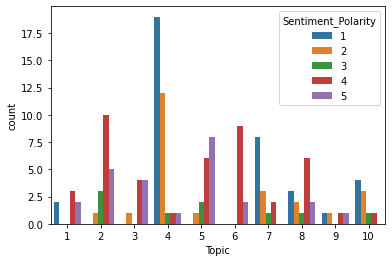

In [30]:
ax = sns.countplot(x="Topic", hue="Sentiment_Polarity", data=sent_data)

In [31]:
simple_sent = sent_data
simple_sent["Sentiment_Polarity"] = simple_sent["Sentiment_Polarity"].replace(to_replace =5,
                 value ="Positive")
simple_sent["Sentiment_Polarity"] = simple_sent["Sentiment_Polarity"].replace(to_replace =4,
                 value ="Positive")
simple_sent["Sentiment_Polarity"] = simple_sent["Sentiment_Polarity"].replace(to_replace =3,
                 value ="Neutral")
simple_sent["Sentiment_Polarity"] = simple_sent["Sentiment_Polarity"].replace(to_replace =2,
                 value ="Negative")
simple_sent["Sentiment_Polarity"] = simple_sent["Sentiment_Polarity"].replace(to_replace =1,
                 value ="Negative")
simple_sent

,Topic,Sentiment_Polarity
0,4,Negative
1,1,Positive
2,7,Positive
3,10,Negative
4,6,Positive
...,...,...
133,10,Negative
134,4,Negative
135,4,Negative
136,5,Positive


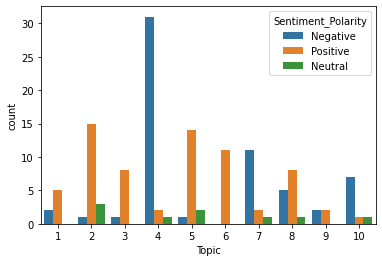

In [32]:

ax = sns.countplot(x="Topic", hue="Sentiment_Polarity", data=simple_sent)

In [34]:
count_series = simple_sent.groupby(['Topic', 'Sentiment_Polarity']).size()
simple_size = count_series.to_frame(name = 'size').reset_index()
t6 = {'Topic': 6, 'Sentiment_Polarity': "Negative", 'size': 0}
simple_size = simple_size.append(t6, ignore_index = True)
simple_size

,Topic,Sentiment_Polarity,size
0,1,Negative,2
1,1,Positive,5
2,2,Negative,1
3,2,Neutral,3
4,2,Positive,15
5,3,Negative,1
6,3,Positive,8
7,4,Negative,31
8,4,Neutral,1
9,4,Positive,2


In [35]:
avg = 0
weight = 0
weighted_avg = 0
for x in range(1,11):
    pos = int(simple_size["size"].loc[(simple_size['Topic'] == x) & (simple_size['Sentiment_Polarity'] == "Positive")])
    neg = int(simple_size["size"].loc[(simple_size['Topic'] == x) & (simple_size['Sentiment_Polarity'] == "Negative")])
    if pos>neg:
        result = pos/(pos+neg)
        print('The probability that comment Topic',x,'will be positive is',result)
        avg = result+avg
        weight= weight + pos+neg
        weighted_avg= weighted_avg + result*(pos+neg)
    else:
        result = neg/(pos+neg)
        print('The probability that comment Topic',x,'will be negative is',result)
        avg = result+avg
        weight= weight + pos+neg
        weighted_avg= weighted_avg + result*(pos+neg)

print("The average correctness of the topics is", avg/10)
print("The weighted avereage correctness of the topics is",weighted_avg/(weight))
            

The probability that comment Topic 1 will be positive is 0.7142857142857143
The probability that comment Topic 2 will be positive is 0.9375
The probability that comment Topic 3 will be positive is 0.8888888888888888
The probability that comment Topic 4 will be negative is 0.9393939393939394
The probability that comment Topic 5 will be positive is 0.9333333333333333
The probability that comment Topic 6 will be positive is 1.0
The probability that comment Topic 7 will be negative is 0.8461538461538461
The probability that comment Topic 8 will be positive is 0.6153846153846154
The probability that comment Topic 9 will be negative is 0.5
The probability that comment Topic 10 will be negative is 0.875
The average correctness of the topics is 0.8249940337440338
The weighted avereage correctness of the topics is 0.8682170542635659
